# UE Localization Visualization

A compact notebook for the core plots and sanity checks.

In [1]:
import sys
import os
from pathlib import Path
import yaml
import torch
import numpy as np
import pandas as pd
from IPython.display import display
import importlib

# Ensure matplotlib renders inline in notebooks
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats('png')
except Exception:
    pass

# Notebook verbosity control
VERBOSE = False

# Get the absolute path to project root
project_root = Path("/home/ubuntu/projects/MapConditionedPose")

if VERBOSE:
    print(f"Project root: {project_root}")

# Change to project root
os.chdir(project_root)

# Add src to path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Force deep reload of all src modules by removing them from cache first
to_remove = [key for key in sys.modules.keys() if key.startswith('src.')]
for key in to_remove:
    del sys.modules[key]

from src.training import UELocalizationLightning
# Note: collate_fn is now None (uses PyTorch default) for LMDB dataset



## 1. Setup

In [13]:
# Resolve checkpoint + dataset paths
from src.notebook_plot_helpers import (
    resolve_checkpoint_and_config,
    resolve_lmdb_paths,
    load_model_and_batch,
    visualize_maps,
    visualize_lidar_height,
    plot_ue_tx_scatter,
    plot_ue_trajectories,
    list_available_scenes,
    visualize_sionna_3d_scene,
    render_prediction,
    compute_evaluation_metrics,
    plot_error_analysis,
    compute_loss_breakdown,
    visualize_coarse_heatmap,
    visualize_fine_refinement,
    plot_error_on_building_map,
)

CHECKPOINT_DIR = 'outputs'
CHECKPOINT_PATH = ''
CHECKPOINT_EPOCH = None
ckpt_notes = []

# For debugging without checkpoint, use direct dataset path
USE_DIRECT_DATASET = True
if USE_DIRECT_DATASET:
    DATASET_PATH = '/home/ubuntu/projects/MapConditionedPose/outputs/experiment_2tx_2vars_1000ue/data/dataset_20260128_144040_test.lmdb'
    BASE_CONFIG_PATH = '/home/ubuntu/projects/MapConditionedPose/outputs/experiment_2tx_2vars_1000ue/config.yaml'
else:
    CHECKPOINT_PATH, BASE_CONFIG_PATH, ckpt_notes = resolve_checkpoint_and_config(
        checkpoint_dir=CHECKPOINT_DIR,
        checkpoint_path=CHECKPOINT_PATH,
        checkpoint_epoch=CHECKPOINT_EPOCH,
    )
    DATASET_PATH, TRAIN_PATH, VAL_PATH, TEST_PATH = resolve_lmdb_paths()

if VERBOSE:
    print(f'Checkpoint: {CHECKPOINT_PATH}')
    print(f'Config: {BASE_CONFIG_PATH}')
    print(f'Dataset: {DATASET_PATH}')
    if ckpt_notes:
        print('Notes:')
        for note in ckpt_notes:
            print(f'- {note}')
elif ckpt_notes:
    print(' | '.join(ckpt_notes))


In [14]:
# Load model and build a batch
TARGET_BATCH_IDX = 1

if USE_DIRECT_DATASET:
    # Direct dataset loading (no checkpoint required)
    import yaml
    from torch.utils.data import DataLoader
    from src.datasets.lmdb_dataset import LMDBRadioLocalizationDataset
    
    # Load config
    with open(BASE_CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    
    # Extract dataset parameters from config
    dataset_config = config.get('dataset', {})
    map_resolution = dataset_config.get('map_resolution', 1.0)
    scene_extent = dataset_config.get('scene_extent', 512)
    normalize = dataset_config.get('normalize', True)
    handle_missing = dataset_config.get('handle_missing', 'mask')
    
    # Create dataset directly
    dataset = LMDBRadioLocalizationDataset(
        lmdb_path=DATASET_PATH,
        split='test',
        map_resolution=map_resolution,
        scene_extent=scene_extent,
        normalize=normalize,
        handle_missing=handle_missing,
    )
    
    # Create dataloader
    val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Get the target batch
    batch_iter = iter(val_loader)
    for i in range(TARGET_BATCH_IDX + 1):
        try:
            batch = next(batch_iter)
        except StopIteration:
            print(f"Reached end of dataset at batch {i}")
            break
    
    # Set model to None since we're not loading from checkpoint
    model = None
    
    print(f"Loaded batch {TARGET_BATCH_IDX} directly from dataset")
    print(f"Dataset has {len(dataset)} samples")
    
else:
    # Original checkpoint-based loading
    model, batch, val_loader = load_model_and_batch(
        CHECKPOINT_PATH,
        BASE_CONFIG_PATH,
        TRAIN_PATH if 'TRAIN_PATH' in globals() else None,
        VAL_PATH if 'VAL_PATH' in globals() else None,
        TEST_PATH if 'TEST_PATH' in globals() else None,
        target_batch_idx=TARGET_BATCH_IDX,
        verbose=VERBOSE,
    )


Loaded batch 1 directly from dataset
Dataset has 5 samples


/home/ubuntu/projects/MapConditionedPose/src/datasets/lmdb_dataset.py:703: ComplexWarning: Casting complex values to real discards the imaginary part
  total_power.astype(np.float32)


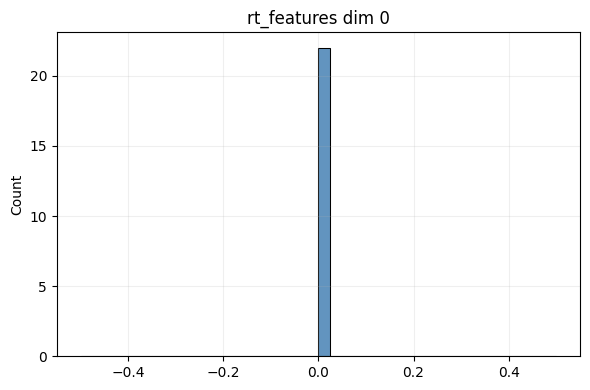

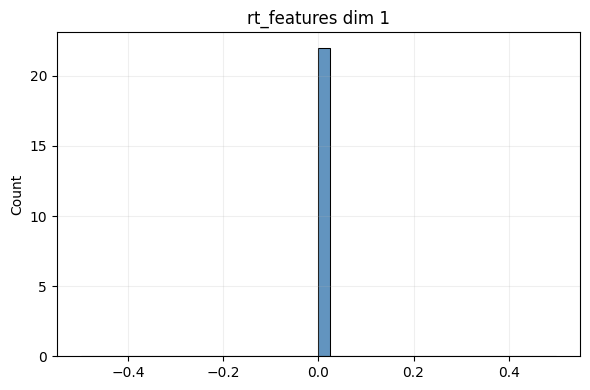

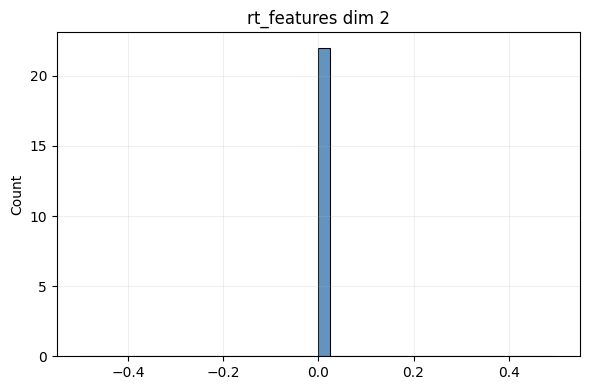

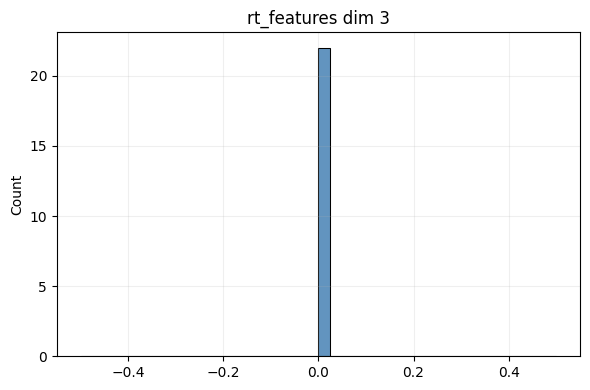

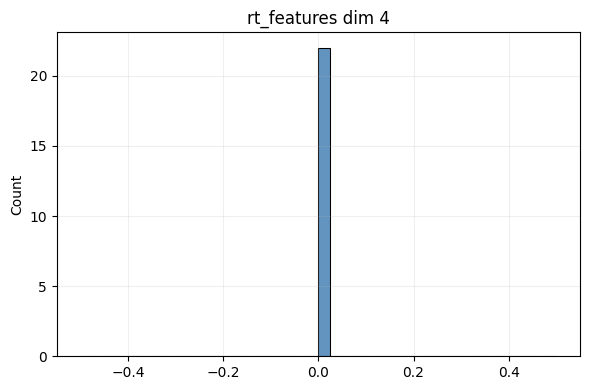

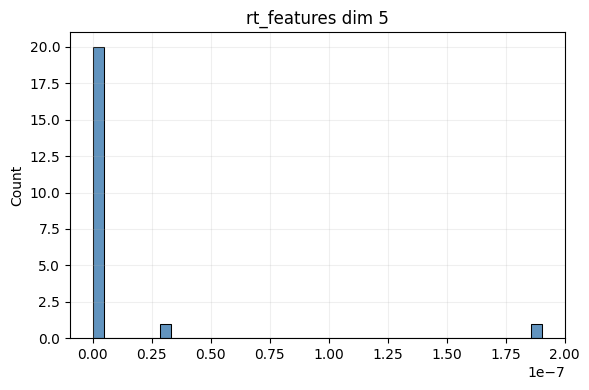

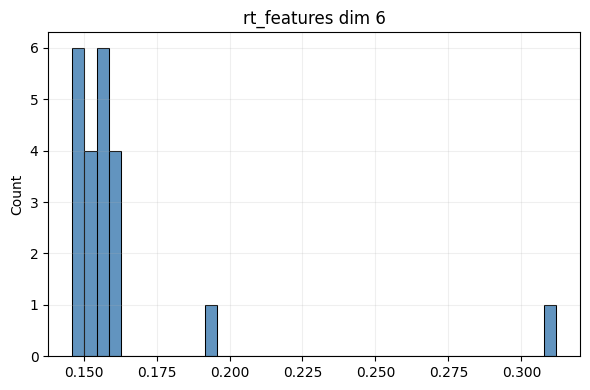

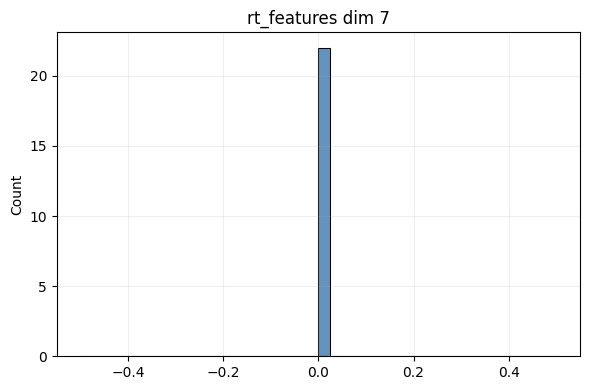

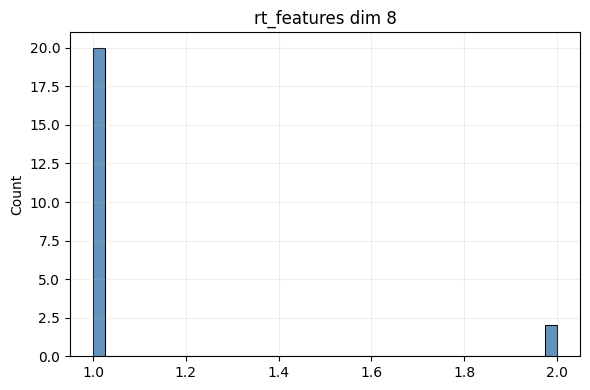

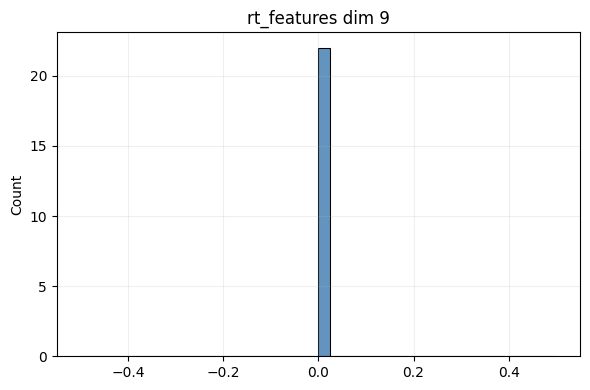

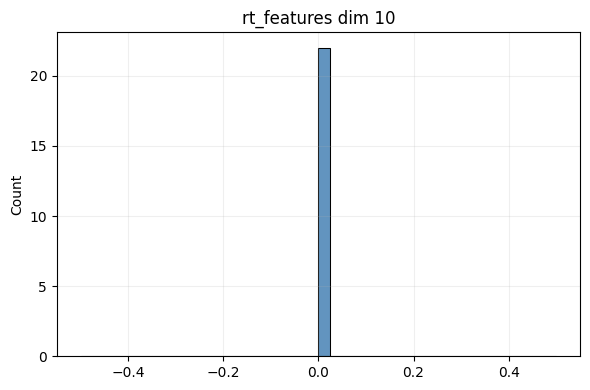

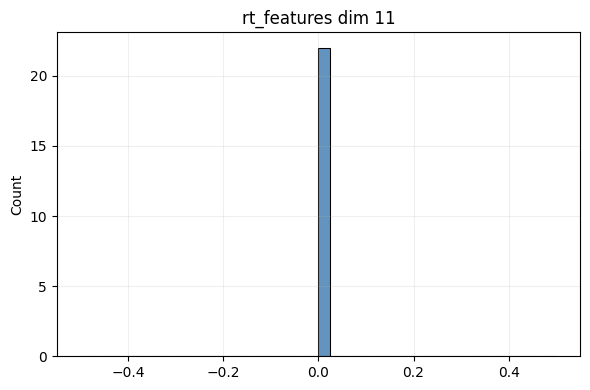

Processing rt_features


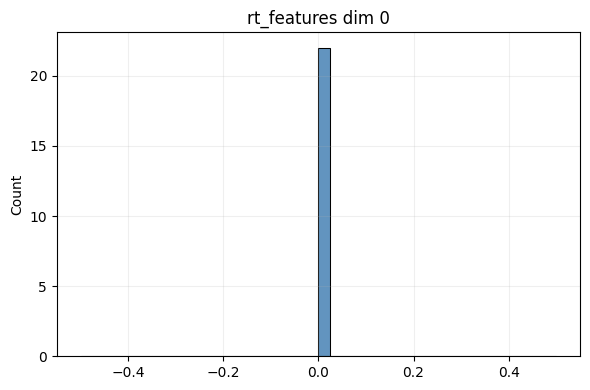

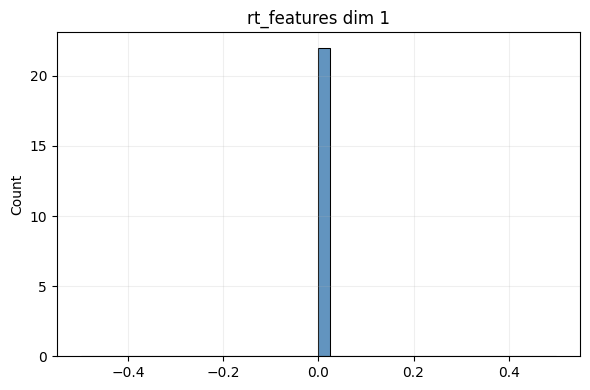

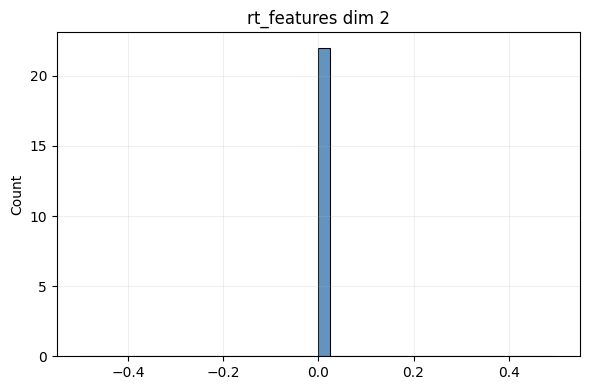

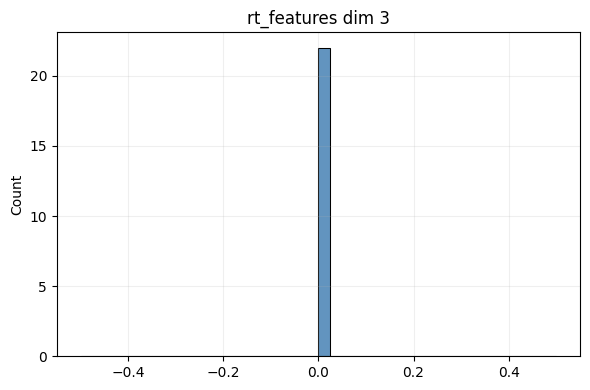

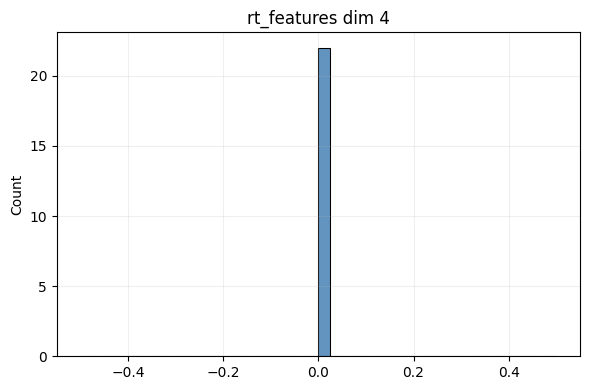

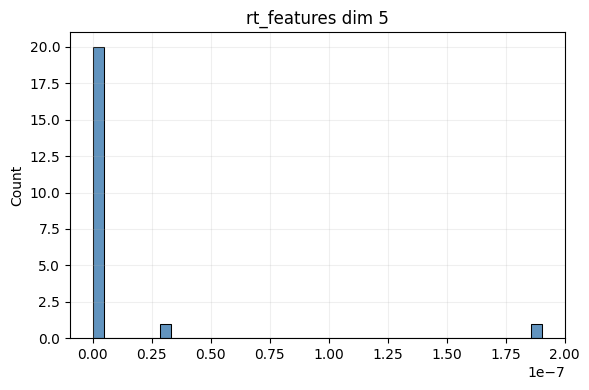

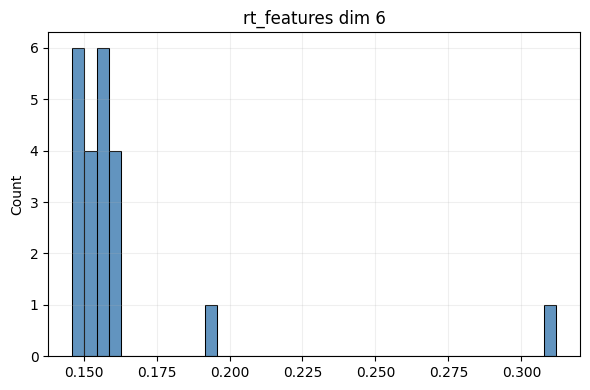

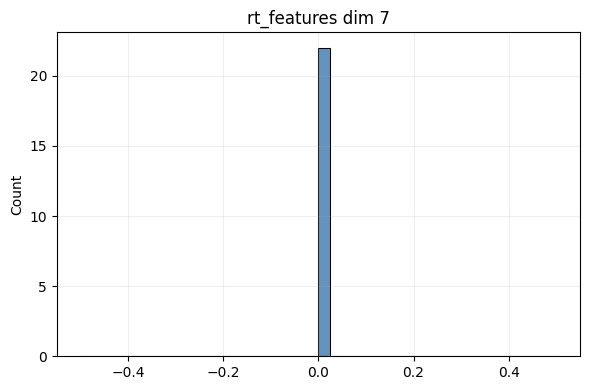

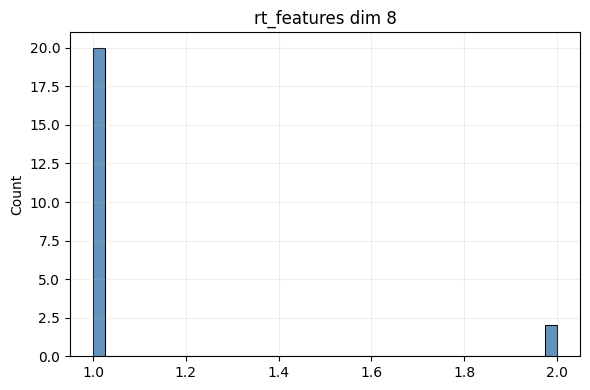

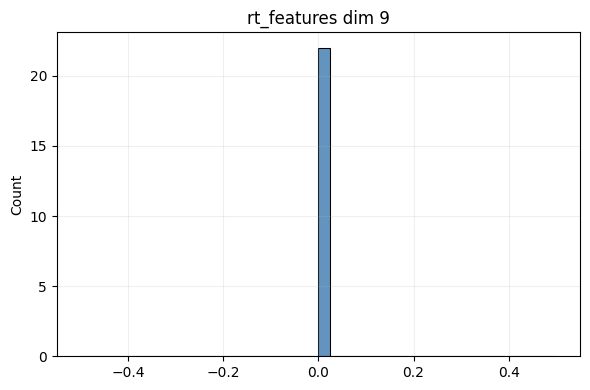

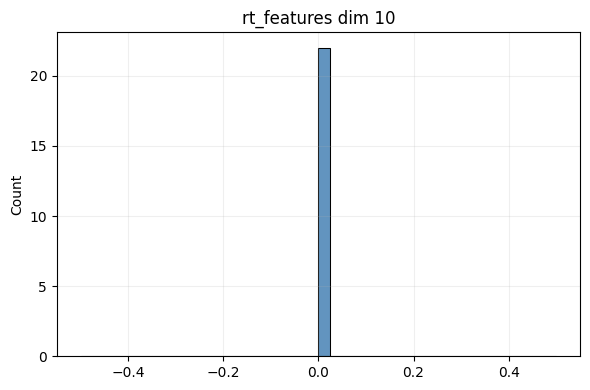

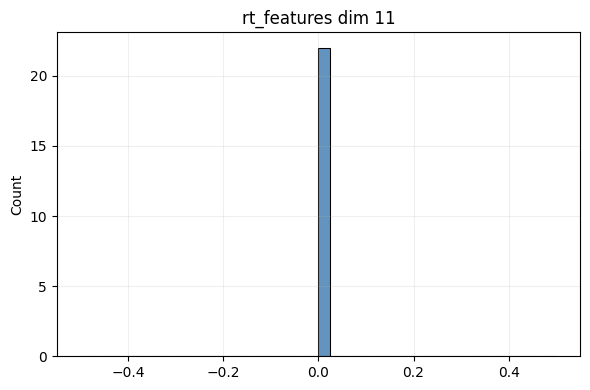

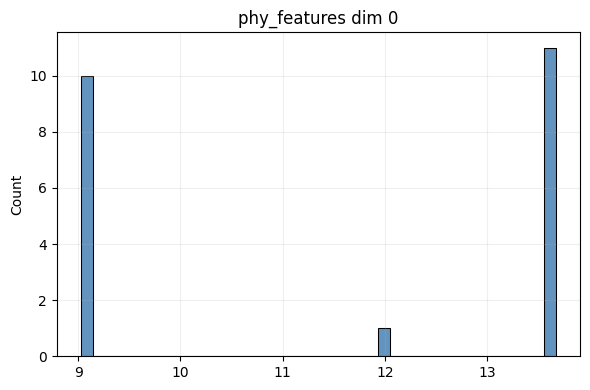

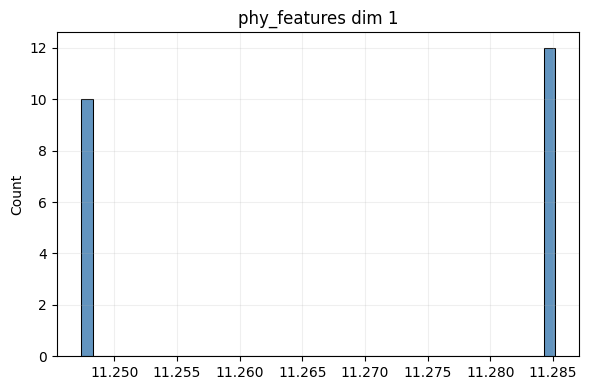

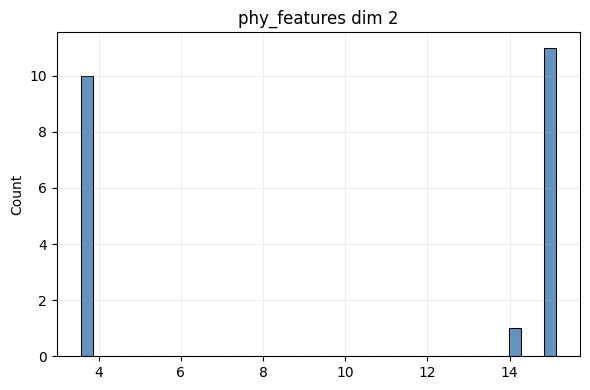

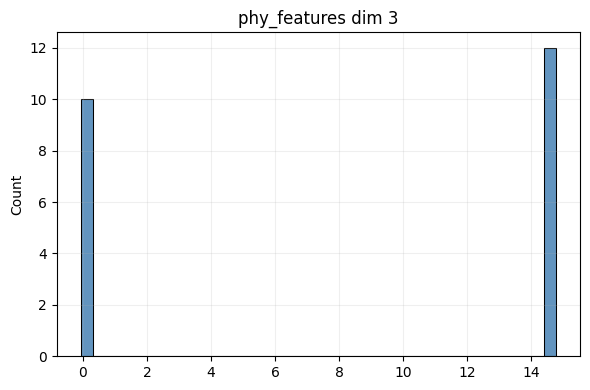

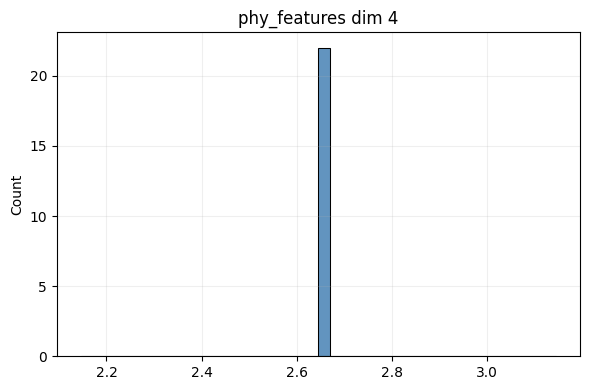

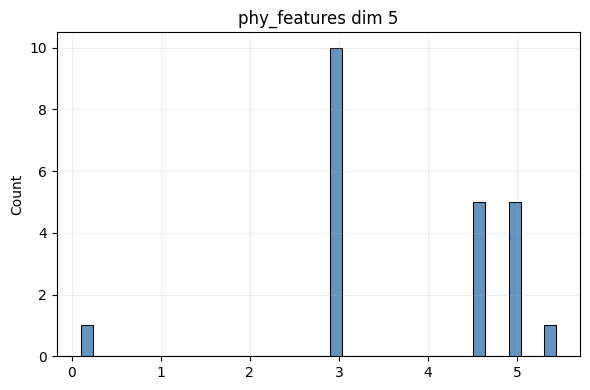

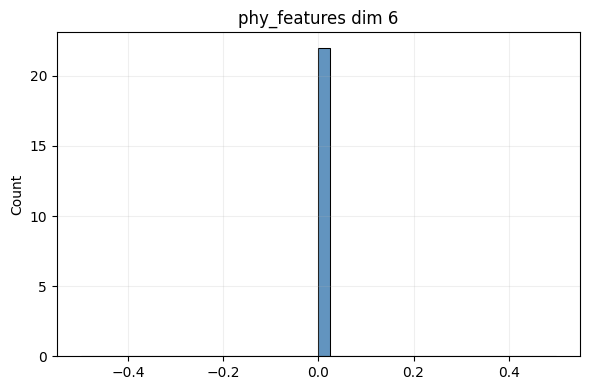

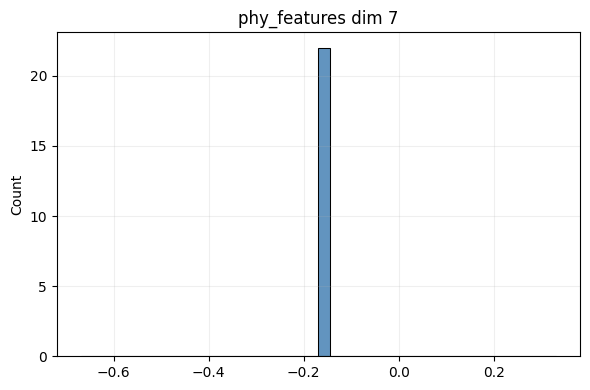

Processing phy_features


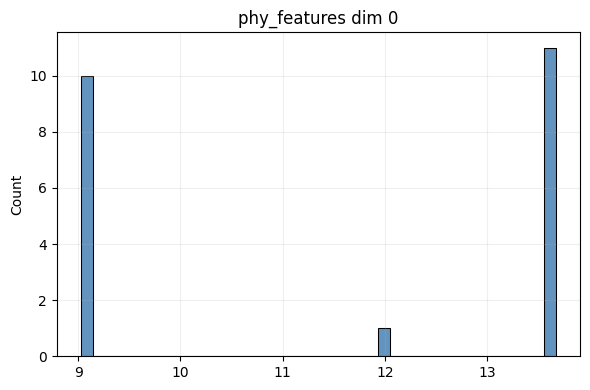

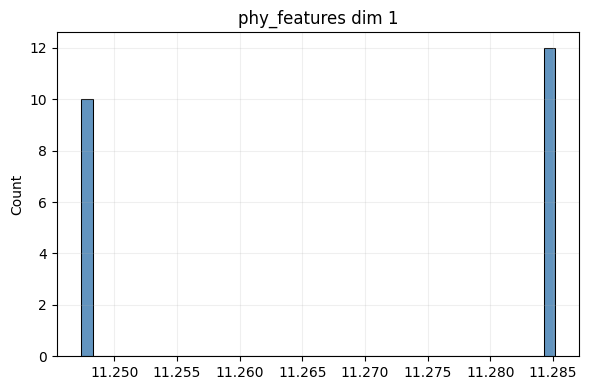

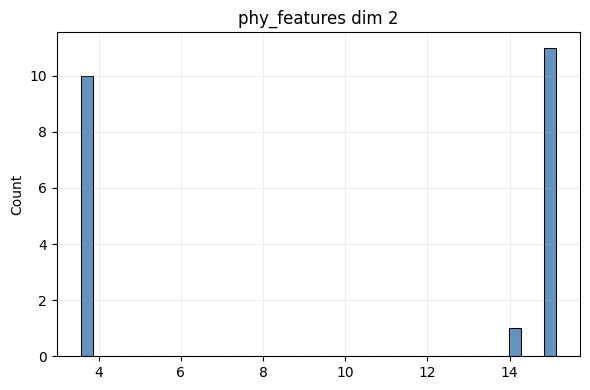

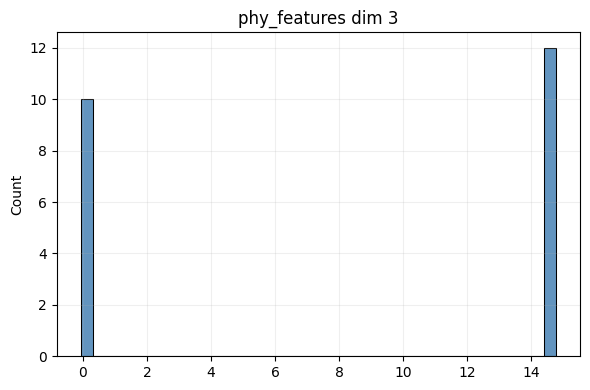

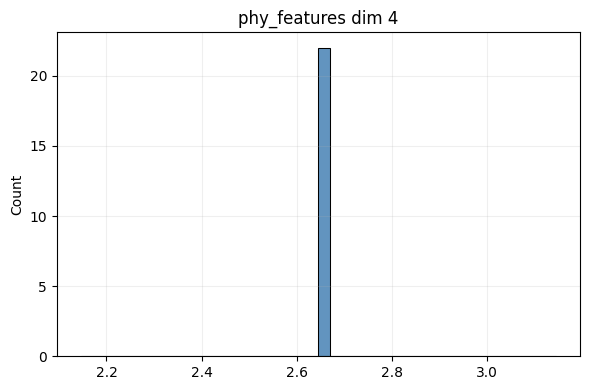

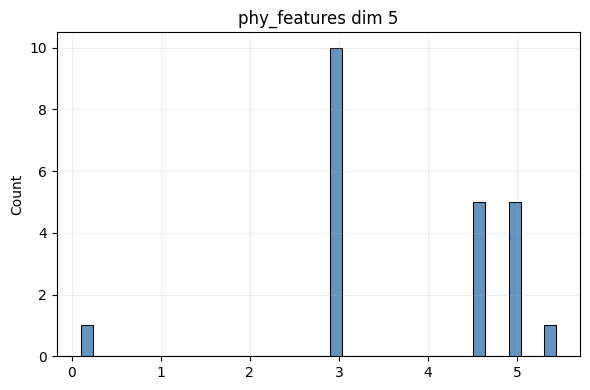

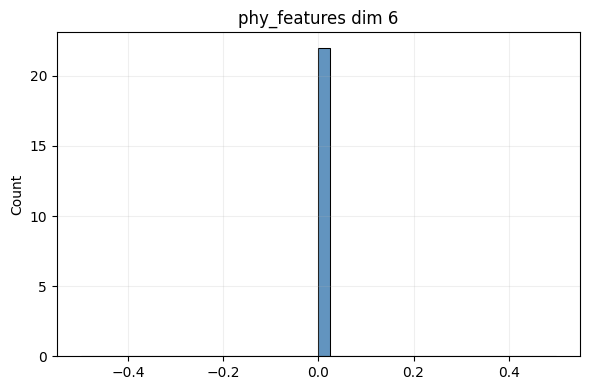

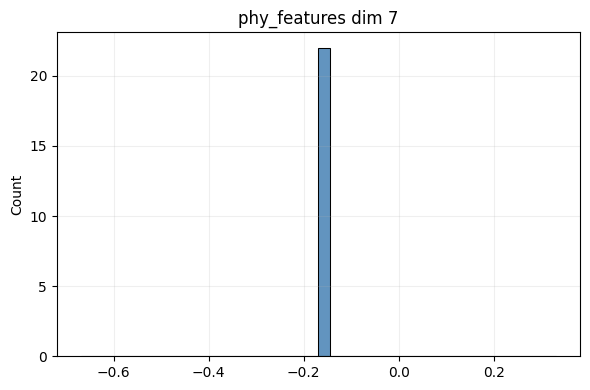

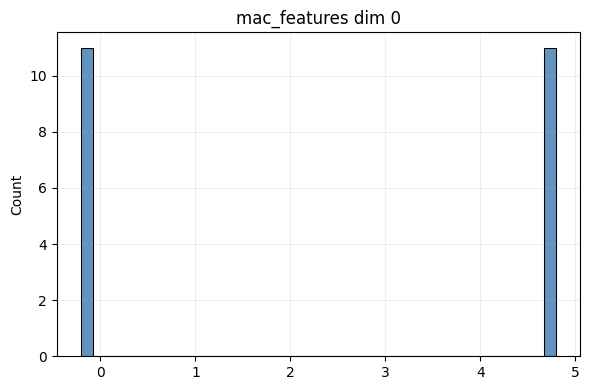

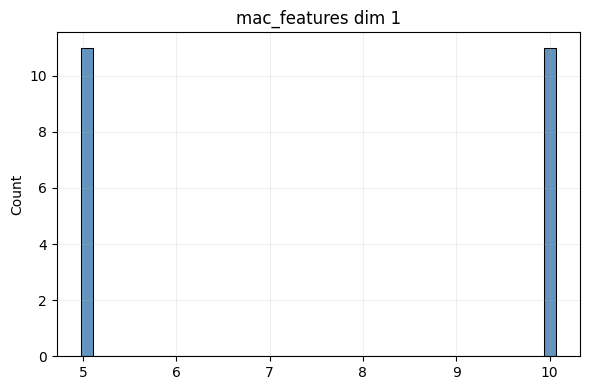

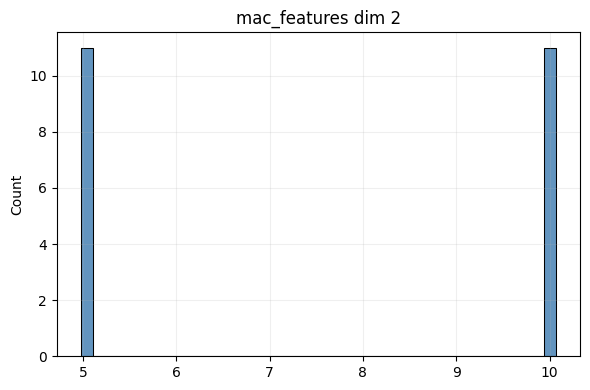

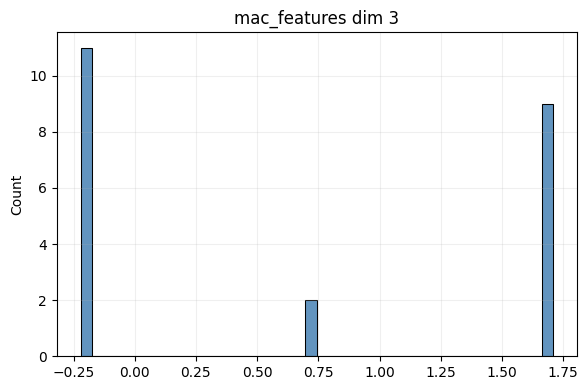

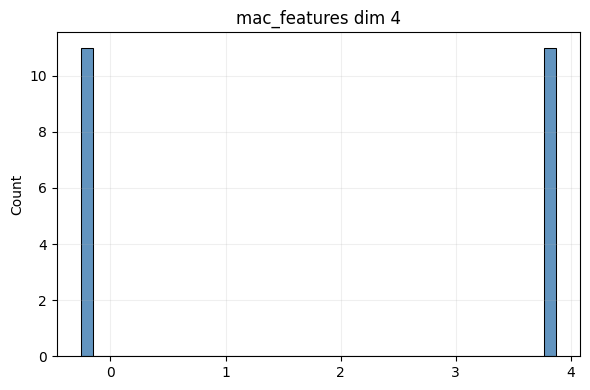

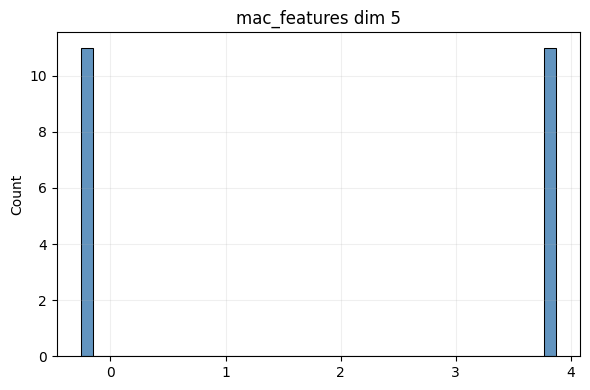

Processing mac_features


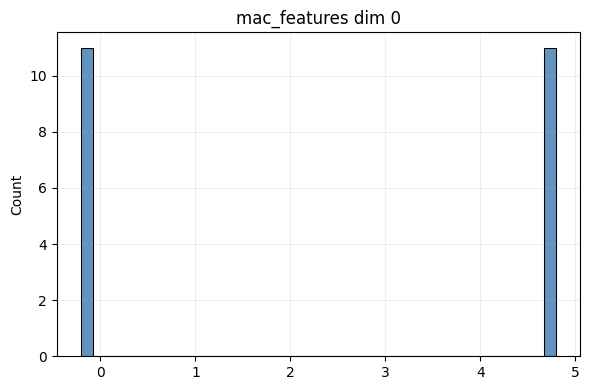

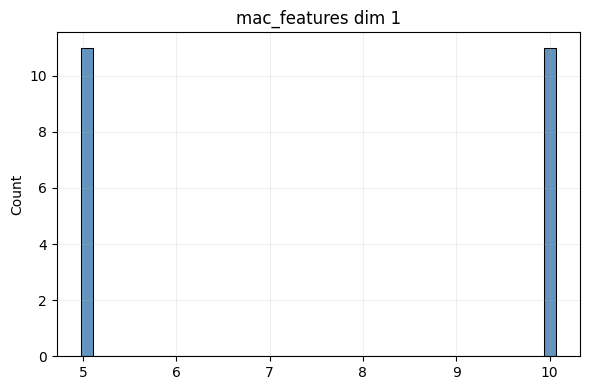

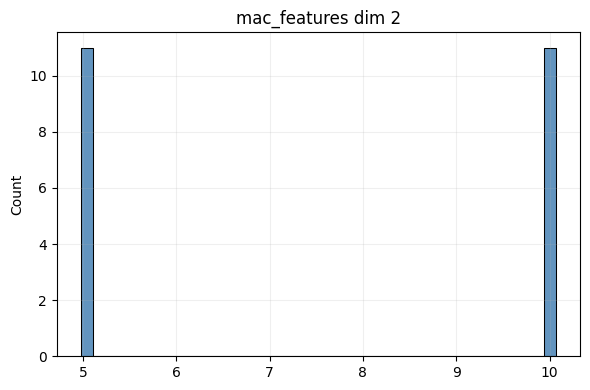

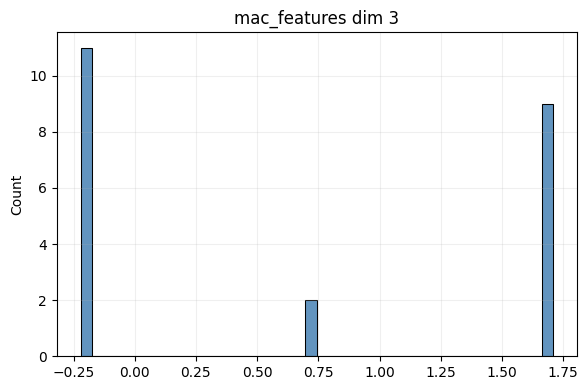

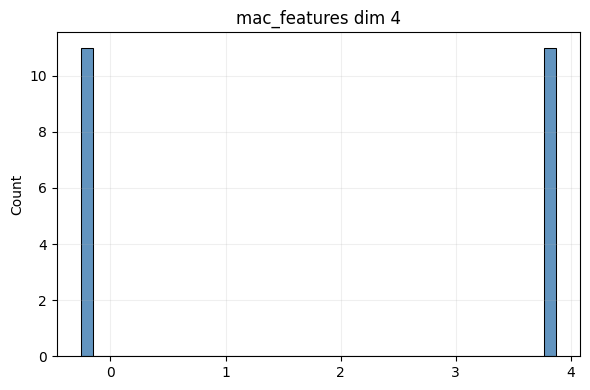

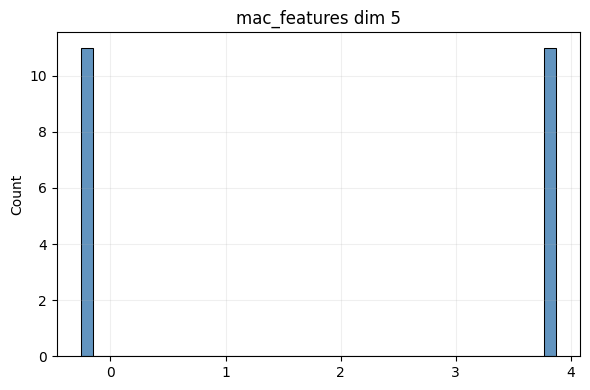

In [15]:
# Feature table (RadioEncoder inputs only)
_ = visualize_feature_histograms(batch, max_dims=12)


In [4]:
SAMPLE_IDX = 0

if 'batch' not in globals():
    raise RuntimeError('batch not defined; run the setup cell above')

SCENE_ID = None
SCENE_IDX = None
GLOBAL_SAMPLE_IDX = None
if 'scene_idx' in batch:
    try:
        SCENE_IDX = int(batch['scene_idx'][SAMPLE_IDX].item())
    except Exception:
        SCENE_IDX = None
if SCENE_IDX is not None and hasattr(val_loader, 'dataset'):
    meta = getattr(val_loader.dataset, '_metadata', None)
    if meta:
        scene_ids = meta.get('scene_ids')
        if scene_ids and 0 <= SCENE_IDX < len(scene_ids):
            SCENE_ID = scene_ids[SCENE_IDX]


## 2. Data sanity

## 3. Map context

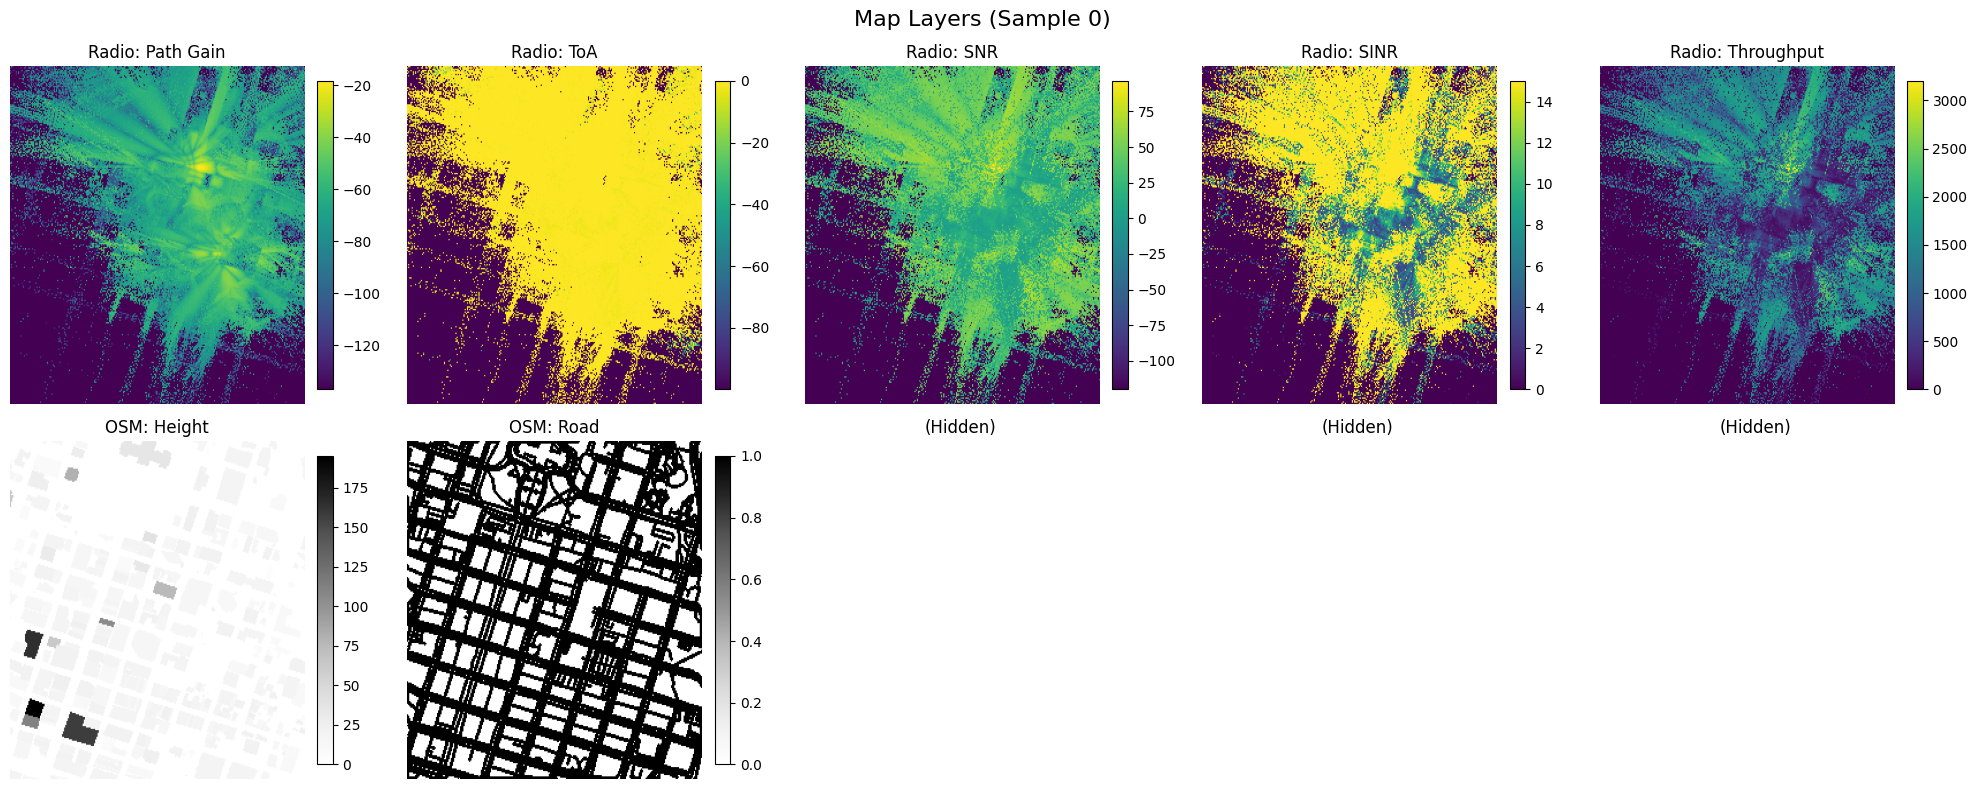

In [16]:
# Map layers
visualize_maps(batch, sample_idx=SAMPLE_IDX)


In [ ]:
# Optional: LiDAR height channel
visualize_lidar_height(batch, sample_idx=SAMPLE_IDX)


In [ ]:
# UE/TX positions
plot_ue_tx_scatter(val_loader.dataset, coord_mode="auto", ue_size=25, ue_alpha=0.6, tx_size=120, scene_id_filter=SCENE_ID)


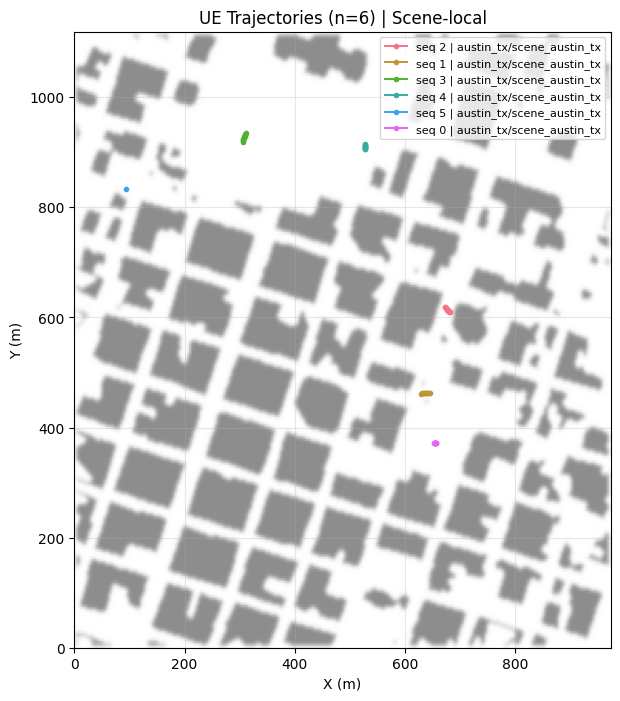

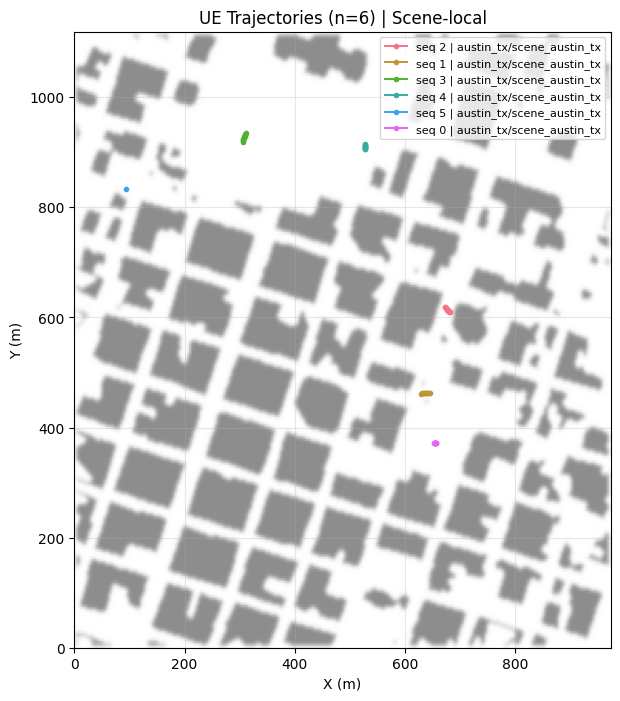

In [17]:
# UE trajectories over map
plot_ue_trajectories(
    val_loader.dataset,
    num_trajectories=12,
    split=val_loader.dataset.split if hasattr(val_loader, "dataset") else "all",
    scene_id_filter=SCENE_ID,
    coord_mode="auto",
    show_map=True,
    save_path="docs/paper/figures/ue_trajectories.png",
)


## 4. 3D Scene

In [ ]:
# 3D Sionna scene render with radio overlay
available = list_available_scenes()
if VERBOSE:
    print(f"Available scenes: {list(available.keys())}")

sionna_radio_map = visualize_sionna_3d_scene(
    batch,
    sample_idx=SAMPLE_IDX,
    scene_name=SCENE_ID,
    verbose=VERBOSE,
    use_sionna=True,
)


## 5. Predictions

In [ ]:
# Model predictions (top-K overlay)
outputs = render_prediction(model, batch, sample_idx=SAMPLE_IDX, verbose=VERBOSE)


In [ ]:
# Coarse heatmap + loss breakdown
losses, outputs = compute_loss_breakdown(model, batch)
visualize_coarse_heatmap(outputs, batch, sample_idx=SAMPLE_IDX)


In [ ]:
# Fine refinement visualization
visualize_fine_refinement(outputs, batch, sample_idx=SAMPLE_IDX)


## 6. Evaluation

In [ ]:
# Error metrics + distributions
metrics, errors_m, pred_pos, true_pos, scene_extent = compute_evaluation_metrics(model, batch)
plot_error_analysis(errors_m, "Batch Error Analysis")


In [ ]:
# Error overlay on building footprint
plot_error_on_building_map(
    model,
    val_loader,
    max_batches=10,
    save_path="docs/paper/figures/error_on_building_map.png",
)
